In [ ]:
!pip install stopwords
!pip install flair
!pip install nltk
!pip install swifter
!pip install pyyaml==5.4.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 636 kB 5.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0


In [ ]:
import pandas as pd
import numpy as np
import flair
from flair.data import Sentence
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random as rn
import seaborn as sns
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter
from PIL import Image
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
pd.options.display.max_rows = None
seed=40

In [ ]:
rn.seed(a=40)
p = 0.1
review = pd.read_csv('/amazon_review.csv',skiprows=lambda i: i>0 and rn.random() > p)
review.shape

(24, 2)

In [ ]:
review.head()

,Review,Rating
0,The media could not be loaded.,4.0
1,"I ordered this Yesterday ,18th July and receiv...",2.0
2,This Airdopes 141 is good for first time user....,4.0
3,The media could not be loaded.\n ...,4.0
4,Product is cheap in quality and also looks.The...,1.0


In [ ]:
def score_round(x):
    if x>=2:
        return 1
    else: 
        return 0

In [8]:
review['review_score']= review.Rating.apply(score_round)

In [9]:
review = review.rename(columns={'Text':'review_text'})

next stage


In [10]:
rn.seed(a=40)
q = 0.8 
review_val = pd.read_csv('/amazon_review.csv',skiprows=lambda i: i>0 and rn.random() > q)
review_val.head()

,Review,Rating
0,"I ordered this Yesterday ,18th July and receiv...",2.0
1,The media could not be loaded.,4.0
2,My review is a little bit long(sorry!) but I h...,4.0
3,Purchase date is 26jul2021Month and year of im...,1.0
4,Honestly what else can you ask for in a tws at...,5.0


In [11]:
review_val['review_score']=review_val.Rating.apply(score_round)

In [12]:
review_val = review_val.rename(columns={'Text':'review_text'})

In [13]:
review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Review        24 non-null     object 
 1   Rating        24 non-null     float64
 2   review_score  24 non-null     int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 704.0+ bytes


In [16]:
review.review_text = review.Review.astype('str')
review_val.review_text = review.Review.astype('str')


In [19]:
temp = review.groupby('review_score').count()['Review'].reset_index().sort_values(by='Review',ascending=False)
temp.style.background_gradient(cmap='Purples')

,review_score,Review
1,1,16
0,0,8


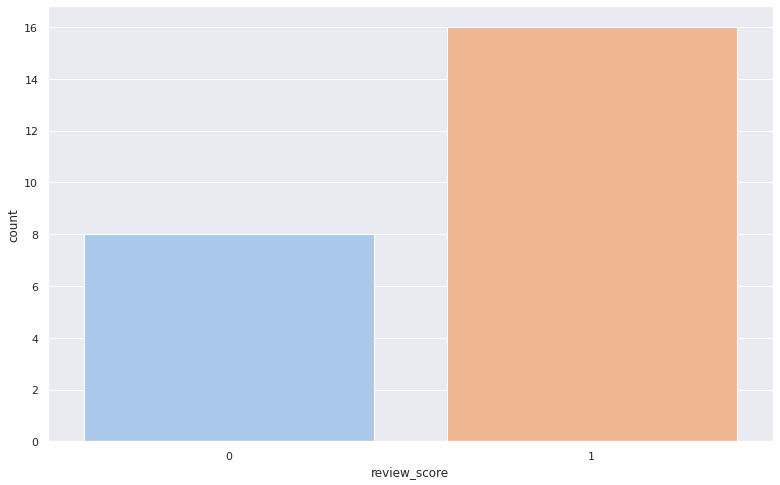

In [20]:
sns.set_theme(style='whitegrid')
sns.set(rc = {'figure.figsize':(13,8)})
sns.set_palette("pastel")
sns.countplot(x='review_score',data=review)

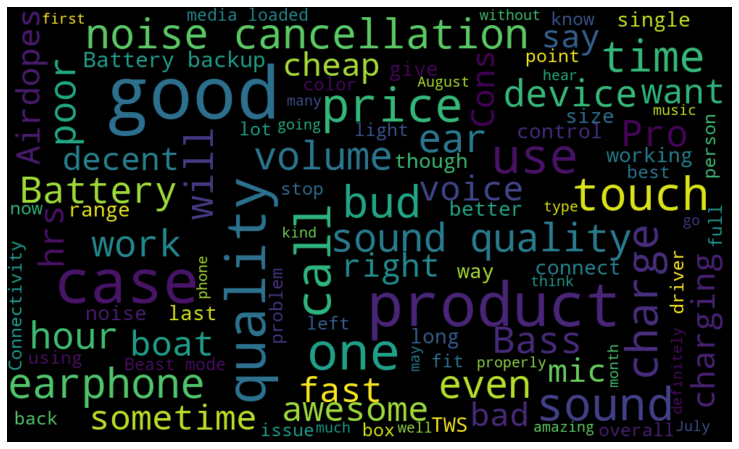

In [21]:
txt = ' '.join(rev for rev in review.review_text)
plt.figure(figsize=(15,8))

wordcloud = WordCloud(
            background_color = 'black',
            max_font_size = 100,
            max_words = 100,
            width = 1000,
            height = 600
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [22]:
positive = review[review['review_score']==1]
negative = review[review['review_score']==0]

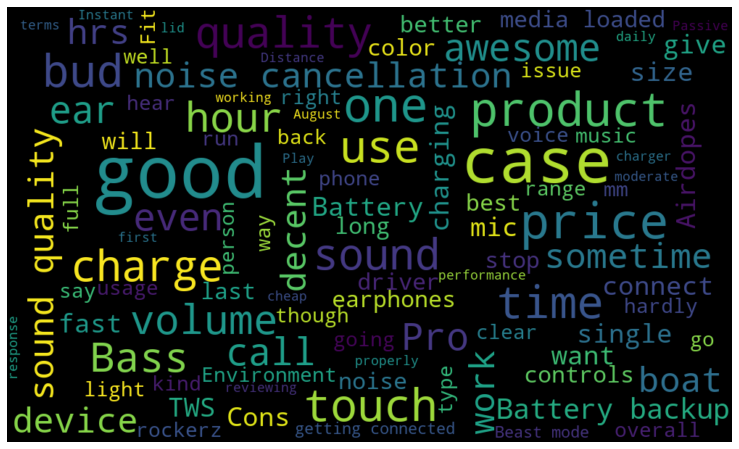

In [24]:
txt = ' '.join(rev for rev in positive.Review)
plt.figure(figsize=(15,8))

wordcloud = WordCloud(
            background_color = 'black',
            max_font_size = 100,
            max_words = 100,
            width = 1000,
            height = 600
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

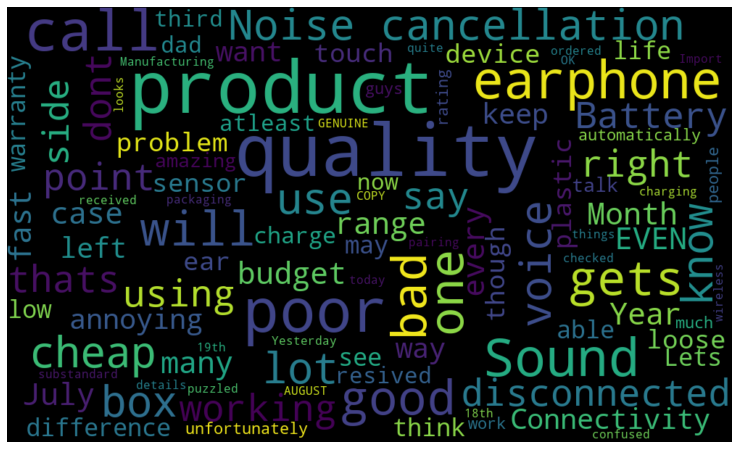

In [26]:
txt = ' '.join(rev for rev in negative.Review)
plt.figure(figsize=(15,8))

wordcloud = WordCloud(
            background_color = 'black',
            max_font_size = 100,
            max_words = 100,
            width = 1000,
            height = 600
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [27]:
review_vis = review.copy()

In [29]:
review_vis['Num_word_review'] = review_vis['Review'].apply(lambda x:len(str(x).split()))

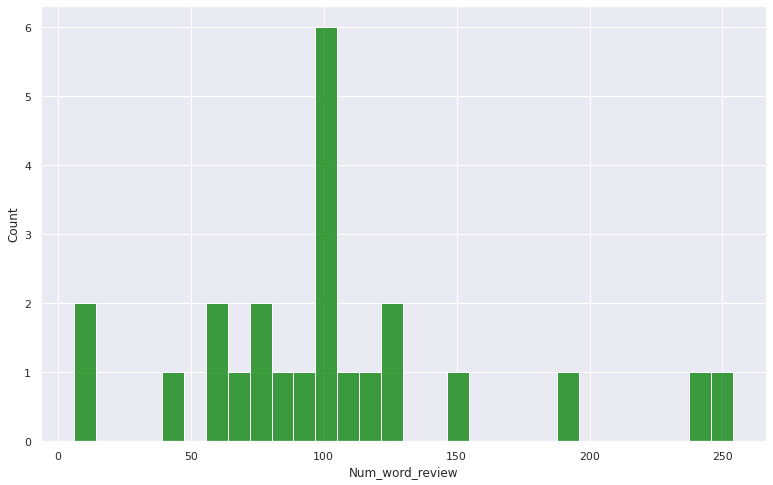

In [30]:
sns.histplot(data=review_vis, x="Num_word_review",bins=30,color='green')

In [32]:
review_vis['temp_list'] = review_vis['Review'].apply(lambda x:str(x).split())
top = Counter([item for sublist in review_vis['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,is,104
1,the,83
2,it,47
3,and,46
4,of,46
5,for,41
6,to,41
7,I,32
8,you,32
9,in,30


In [33]:
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
nltk.download('stopwords')
from nltk.stem import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [34]:
review.isnull().sum()

Review          0
Rating          0
review_score    0
dtype: int64

In [35]:
review = review.drop_duplicates(keep='first')

In [36]:
review.shape

(24, 3)

In [37]:
def clean(raw):
    """ Remove hyperlinks and markup """
    result = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', raw)
    result = re.sub('&gt;', "", result)
    result = re.sub('&#x27;', "'", result)
    result = re.sub('&quot;', '"', result)
    result = re.sub('&#x2F;', ' ', result)
    result = re.sub('<p>', ' ', result)
    result = re.sub('</i>', '', result)
    result = re.sub('&#62;', '', result)
    result = re.sub('<i>', ' ', result)
    result = re.sub("\n", '', result)
    return result

In [38]:
def remove_num(texts):
   output = re.sub(r'\d+', '', texts)
   return output

In [39]:
def deEmojify(x):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'', x)

In [40]:
def unify_whitespaces(x):
    cleaned_string = re.sub(' +', ' ', x)
    return cleaned_string

In [41]:
def remove_symbols(x):
    cleaned_string = re.sub(r"[^a-zA-Z0-9?!.,]+", ' ', x)
    return cleaned_string

In [42]:
def remove_punctuation(text):
    final = "".join(u for u in text if u not in ("?", ".", ";", ":",  "!",'"',','))
    return final

In [43]:
stop=set(stopwords.words("english"))
stemmer=PorterStemmer()
lemma=WordNetLemmatizer()

def remove_stopword(text):
   text=[word.lower() for word in text.split() if word.lower() not in stop]
   return " ".join(text)

In [44]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
def Stemming(text):
   stem=[]
   stopword = stopwords.words('english')
   snowball_stemmer = SnowballStemmer('english')
   word_tokens = nltk.word_tokenize(text)
   stemmed_word = [snowball_stemmer.stem(word) for word in word_tokens]
   stem=' '.join(stemmed_word)
   return stem

In [45]:
def cleaning(df,review):
    df[review] = df[review].apply(clean)
    df[review] = df[review].apply(deEmojify)
    df[review] = df[review].str.lower()
    df[review] = df[review].apply(remove_num)
    df[review] = df[review].apply(remove_symbols)
    df[review] = df[review].apply(remove_punctuation)
    df[review] = df[review].apply(remove_stopword)
    df[review] = df[review].apply(unify_whitespaces)

In [46]:
cleaning(review,'Review')

In [47]:
review.isnull().sum()

Review          0
Rating          0
review_score    0
dtype: int64

In [48]:
review[['Review']].head(20)

,Review
0,media could loaded
1,ordered yesterday th july received today th ju...
2,airdopes good first time user simply going des...
3,media could loaded sounds amazing kind sound t...
4,product cheap quality also looksthere good poi...
5,keep short simple kindly note reviewing hrs pu...
6,decent product fits comfortable ears long time...
7,best feature earphones iwp instant wake pair t...
8,device working though charged want claim warranty
9,overall everything top class one thingwhich en...


In [49]:
review_vis2 = review.copy()

In [50]:
review_vis2['temp_list'] = review_vis2['Review'].apply(lambda x:str(x).split())
top = Counter([item for sublist in review_vis2['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,good,31
1,quality,26
2,product,20
3,case,20
4,sound,17
5,one,16
6,use,14
7,noise,13
8,price,12
9,charge,11


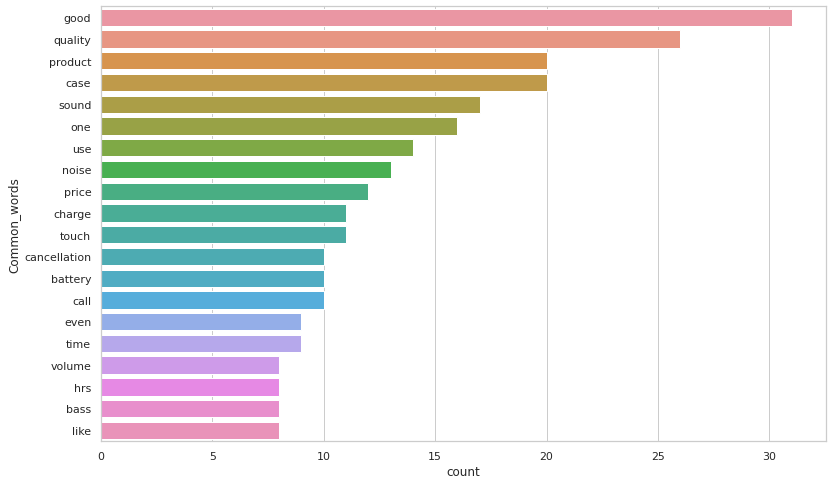

In [51]:
sns.set_theme(style="whitegrid")
sns.barplot(x="count", y="Common_words", data=temp)

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tokenizers import BertWordPieceTokenizer
import transformers
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
import logging
transformers.logging.set_verbosity_error()


In [56]:
training_sentences, test_sentences, training_labels, test_labels = train_test_split(reviews, labels, test_size=.4)

validation_sentences, holdout_sentences, validation_labels, holdout_labels = train_test_split(test_sentences, test_labels, test_size=.5)

In [57]:
reviews = review["Review"].values.tolist()
labels = review["Rating"].tolist()

In [54]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [58]:
tokenizer([training_sentences[0]], truncation=True,
                            padding=True, max_length=512)

{'input_ids': [[101, 2213, 3317, 2875, 1350, 1176, 6929, 3317, 6929, 7352, 2213, 1329, 2366, 3142, 4942, 1838, 2489, 1158, 177, 1733, 1329, 4647, 18360, 4534, 23392, 8352, 1341, 9241, 1840, 3007, 12277, 10681, 3161, 2630, 1974, 16278, 190, 2037, 1840, 2108, 1825, 1334, 1840, 3014, 1734, 1682, 2037, 1840, 1202, 6633, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [59]:
train_encodings = tokenizer(training_sentences,
                            truncation=True,
                            padding=True)

validation_encodings = tokenizer(validation_sentences,
                            truncation=True,
                            padding=True)

holdout_encodings = tokenizer(holdout_sentences,
                            truncation=True,
                            padding=True)

In [84]:
train_dataset = tf.data.Dataset.from_tensor_slices((
                            dict(train_encodings),
                            training_labels
                            ));

validation_dataset = tf.data.Dataset.from_tensor_slices((
                            dict(validation_encodings),
                            validation_labels
                            ));

holdout_dataset = tf.data.Dataset.from_tensor_slices((
                            dict(holdout_encodings),
                            holdout_labels
                            ));

In [104]:
#dict(validation_encodings)
# print(train_dataset)
# print(validation_dataset)
for X,Y in train_dataset:
  print(X,Y)
  break

{'input_ids': <tf.Tensor: shape=(116,), dtype=int32, numpy=
array([  101,  2213,  3317,  2875,  1350,  1176,  6929,  3317,  6929,
        7352,  2213,  1329,  2366,  3142,  4942,  1838,  2489,  1158,
         177,  1733,  1329,  4647, 18360,  4534, 23392,  8352,  1341,
        9241,  1840,  3007, 12277, 10681,  3161,  2630,  1974, 16278,
         190,  2037,  1840,  2108,  1825,  1334,  1840,  3014,  1734,
        1682,  2037,  1840,  1202,  6633,   102,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0],
      dtype=int32)>, 'token_type_ids

In [61]:
model = TFBertForSequenceClassification.from_pretrained('bert-base-cased',num_labels=2)

Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

In [105]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08)
model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy'])

In [71]:
!pip install numpy== 1.19.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement numpy== (from versions: 1.3.0, 1.4.1, 1.5.0, 1.5.1, 1.6.0, 1.6.1, 1.6.2, 1.7.0, 1.7.1, 1.7.2, 1.8.0, 1.8.1, 1.8.2, 1.9.0, 1.9.1, 1.9.2, 1.9.3, 1.10.0.post2, 1.10.1, 1.10.2, 1.10.4, 1.11.0, 1.11.1, 1.11.2, 1.11.3, 1.12.0, 1.12.1, 1.13.0rc1, 1.13.0rc2, 1.13.0, 1.13.1, 1.13.3, 1.14.0rc1, 1.14.0, 1.14.1, 1.14.2, 1.14.3, 1.14.4, 1.14.5, 1.14.6, 1.15.0rc1, 1.15.0rc2, 1.15.0, 1.15.1, 1.15.2, 1.15.3, 1.15.4, 1.16.0rc1, 1.16.0rc2, 1.16.0, 1.16.1, 1.16.2, 1.16.3, 1.16.4, 1.16.5, 1.16.6, 1.17.0rc1, 1.17.0rc2, 1.17.0, 1.17.1, 1.17.2, 1.17.3, 1.17.4, 1.17.5, 1.18.0rc1, 1.18.0, 1.18.1, 1.18.2, 1.18.3, 1.18.4, 1.18.5, 1.19.0rc1, 1.19.0rc2, 1.19.0, 1.19.1, 1.19.2, 1.19.3, 1.19.4, 1.19.5, 1.20.0rc1, 1.20.0rc2, 1.20.0, 1.20.1, 1.20.2, 1.20.3, 1.21.0rc1, 1.21.0rc2, 1.21.0, 1.21.1, 1.21.2, 1.21.3, 1.21.4, 1.21.5, 1.21.6)
ERROR: No matching distri

Epoch 1/3


AttributeError: ignored